In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

In [2]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0〜1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="data", train=False, transform=trans, download=True)

In [3]:
mnist_train.data.shape, mnist_test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [4]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的⽂本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


from matplotlib import pyplot as plt


def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图⽚张量
            ax.imshow(img.numpy())
        else:
            # PIL图⽚
            ax.imshow(img)
        # 关闭坐标轴
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

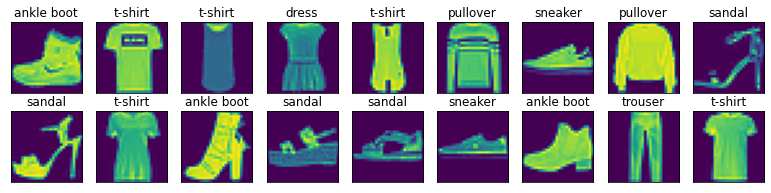

In [23]:
# 可视化数据
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [24]:
batch_size = 256
# 测试不同读取数据的进程数，加载数据耗时
import time

for thread_num in [1, 2, 4, 6, 8, 12]:
    train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                                 num_workers=thread_num)
    start = time.time()
    for X, y in train_iter:
        continue
    print("thread_num:{},cost:{}".format(thread_num, time.time() - start))

thread_num:1,cost:3.714344024658203
thread_num:2,cost:2.559849977493286
thread_num:4,cost:2.1814262866973877
thread_num:6,cost:2.461258888244629
thread_num:8,cost:3.028099298477173
thread_num:12,cost:3.4482407569885254


In [25]:
# 实验显示batch_size=256,4个线程最优
def get_dataloader_workers():
    return 4


# 加载数据函数
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))


train_iter, test_iter = load_data_fashion_mnist(256)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64


In [26]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [27]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition


X = torch.normal(0, 1, (3, 3))
print(X)  #随机生成正态分布数据
softmax(X)  #softmax处理结果
print(softmax(X).sum(axis=1))  #按行累加概率为1

tensor([[-0.4015,  0.1331,  0.6167],
        [-0.6324, -1.7207, -1.5168],
        [ 0.4208, -1.9567,  1.1473]])
tensor([1., 1., 1.])


In [28]:
# 定义基于Softmax的网络模型
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

In [29]:
# 定义损失函数，采用交叉熵作为损失函数
"""
计算原理：
创建⼀个数据样本y_hat，其中包含2个样本在3个类别的预测概率，以及它们对应的标签y。
有了y，我们知道在第⼀个样本中，第⼀类是正确的预测；而在第⼆个样本中，第三类是正确的预测。
然后使⽤y作为y_hat中概率的索引，我们选择第⼀个样本中第⼀个类的概率和第⼆个样本中第三个类的概率
"""
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]  #这样就选中了0.1和0.5

tensor([0.1000, 0.5000])

In [30]:
# 交叉熵
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])


cross_entropy(y_hat, y)  #即-log(0.1)和-log(0.5)

tensor([2.3026, 0.6931])

In [31]:
# 计算预测精度
"""
如果y_hat是矩阵，那么假定第⼆个维度存储每个类的预测分数。
使⽤argmax获得每⾏中最⼤元素的索引来获得预测类别。然后我们将预测类别与真实y元素进⾏⽐较。由
于等式运算符“==”对数据类型很敏感，因此我们将y_hat的数据类型转换为与y的数据类型⼀致。结果是⼀
个包含0（错）和1（对）的张量。最后，我们求和会得到正确预测的数量。
"""


def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    # 将y_hat进行类型转换
    cmp = y_hat.type(y.dtype) == y
    # 返回预测正确的个数
    return float(cmp.type(y.dtype).sum())


accuracy(y_hat, y)

1.0

In [32]:
# 对于任意数据迭代器data_iter可访问的数据集，我们可以评估在任意模型net的精度
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


"""
定义⼀个实⽤程序类Accumulator，⽤于对多个变量进⾏累加。在上面的evaluate_accuracy函数中，
Accumulator实例中创建了2个变量，分别⽤于存储正确预测的数量和预测的总数量。当我们遍历数据集
时，两者都将随着时间的推移而累加
"""


class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


evaluate_accuracy(net, test_iter)

0.109

In [33]:
# 训练
def train_epoch_ch3(net, train_iter, loss, updater, num_epochs):
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    result = [None] * num_epochs
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 计算梯度并更新参数
            y_hat = net(X)
            l = loss(y_hat, y)
            if isinstance(updater, torch.optim.Optimizer):
                # 使⽤PyTorch内置的优化器和损失函数
                updater.zero_grad()
                l.mean().backward()
                updater.step()
            else:
                # 使⽤定制的优化器和损失函数
                l.sum().backward()
                updater(X.shape[0])
                metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
        # 每轮的训练损失和训练精度
        result[epoch] = [metric[0] / metric[2], metric[1] / metric[2]]
        # 用测试集测试精度
        print(result[epoch], evaluate_accuracy(net, test_iter))
    return result


def updater(params, lr):
    def sgd(batch_size):
        with torch.no_grad():
            for param in params:
                param -= lr * param.grad / batch_size
                param.grad.zero_()

    return sgd

In [34]:
train_epoch_ch3(net, train_iter, cross_entropy, updater([W,b],0.1), 10)

[0.787688518969218, 0.7462166666666666] 0.7685
[0.6794517936388651, 0.7794916666666667] 0.8092
[0.6279768189324273, 0.79495] 0.8076
[0.5962209495067596, 0.8043958333333333] 0.819
[0.5739448523585001, 0.8109733333333333] 0.8225
[0.5572840885056389, 0.8157416666666667] 0.8185
[0.5440777263459705, 0.8195761904761905] 0.8303
[0.5333576839288076, 0.8227104166666667] 0.8305
[0.5243309404726382, 0.8253537037037038] 0.828
[0.516628779220581, 0.8276216666666667] 0.8345


[[0.787688518969218, 0.7462166666666666],
 [0.6794517936388651, 0.7794916666666667],
 [0.6279768189324273, 0.79495],
 [0.5962209495067596, 0.8043958333333333],
 [0.5739448523585001, 0.8109733333333333],
 [0.5572840885056389, 0.8157416666666667],
 [0.5440777263459705, 0.8195761904761905],
 [0.5333576839288076, 0.8227104166666667],
 [0.5243309404726382, 0.8253537037037038],
 [0.516628779220581, 0.8276216666666667]]

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

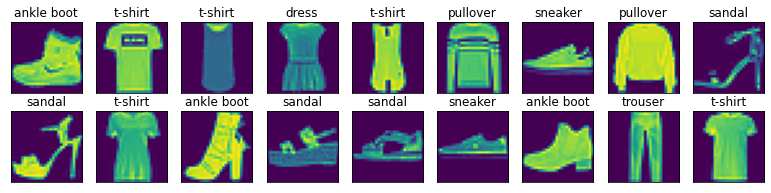

In [42]:
testX, testy = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(testX.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(testy))

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

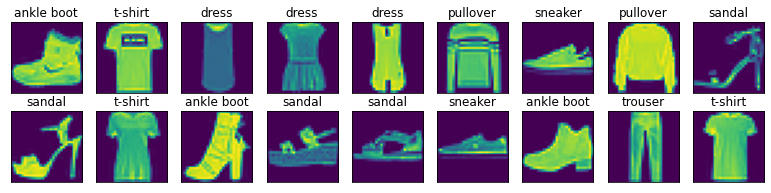

In [43]:
show_images(testX.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(torch.argmax(net(testX),axis=1)))

In [45]:
(testy==torch.argmax(net(testX),axis=1)).sum()/len(testy)

tensor(0.8889)